### Libraries Import

In [31]:
import os
import glob
import time
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
import keras
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Lambda
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image as kimage
from keras.applications.vgg16 import preprocess_input
import scipy.spatial.distance
import pickle
%matplotlib inline

### Dataset import

In [2]:
def read_image(img_path):
    img = kimage.load_img(img_path)
    x = kimage.img_to_array(img)
    return x
start = time.time()
consolidated_jpgdir = '/mnt/data/style_transfers/datasets/consolidated/jpg/'
selected_traversals = ['A000', 'A003', 'A058', 'A059', 'A064', 'A155', 'A159', 'A035', 'A037', 'A079', 'A086', 'A150', 'A151', 'A025', 'A026', 'A062', 'A063', 'A064', 'A138','A164']
test_traversals = ['A007', 'A016', 'A047', 'A059']
filenames = []
test_filenames = []
for traversal in selected_traversals:
    filenames.append(consolidated_jpgdir + traversal + "_000.000..jpg")
for traversal in test_traversals:
    test_filenames.append(consolidated_jpgdir + traversal + "_000.000..jpg")
filenames = sorted(filenames)
test_filenames = sorted(test_filenames)
img = read_image(filenames[0])
(H, W, D) = img.shape
images = np.zeros((len(filenames), H, W, D), dtype=np.uint8)
test_images = np.zeros((len(test_filenames), H, W, D), dtype=np.uint8)
for i, filename in enumerate(filenames):
    images[i,:] = read_image(filename)
for i, filename in enumerate(test_filenames):
    test_images[i,:] = read_image(filename)
print ('[INFO] {} images loaded in {:.1f} seconds.'.format(len(filenames)+len(test_filenames), (time.time()-start)))

[INFO] 24 images loaded in 0.2 seconds.


#### Getting the horizontal offset from ground truth

In [3]:
consolidated_gtdir = '/mnt/data/style_transfers/datasets/consolidated/gtnew/'
gt = np.zeros((len(filenames)), dtype=int)
test_gt = np.zeros((len(test_filenames)), dtype=int)
gt_filenames = []
gt_testfilenames = []
for traversal in selected_traversals:
    gt_filenames.append(consolidated_gtdir + traversal + '_annotation.txt')
for traversal in test_traversals:
    gt_testfilenames.append(consolidated_gtdir + traversal + '_annotation.txt')
gt_filenames = sorted(gt_filenames)
gt_testfilenames = sorted(gt_testfilenames)
for i, filename in enumerate(gt_filenames):
    data = []
    with open(filename, "r") as f:
        data = f.read()
    data = data.split("\n")
    data = list(filter(None, data))
    (_, _,horizontal,_) = [int(k) for k in data[0].split(" ")[:-1]]
    gt[i] = horizontal 
for i, filename in enumerate(gt_testfilenames):
    data = []
    with open(filename, "r") as f:
        data = f.read()
    data = data.split("\n")
    data = list(filter(None, data))
    (_,_,horizontal,_) = [int(k) for k in data[0].split(" ")[:-1]]
    test_gt[i] = horizontal 
print("[INFO] Ground truth loaded.")

[INFO] Ground truth loaded.


In [4]:
gt_ = list(filter(lambda x: x < 500 and x > -500, gt))
gt_mean = np.mean([np.mean(gt__) for gt__ in gt_])
gt_median = np.median([np.median(gt__) for gt__ in gt_])
gt_min = np.min([np.min(gt__) for gt__ in gt_])
gt_max = np.max([np.max(gt__) for gt__ in gt_])

print('MEAN: ', gt_mean, '\nMEDIAN:', gt_median, "\nMIN:", gt_min, "\nMAX:", gt_max)

MEAN:  -17.5 
MEDIAN: -15.0 
MIN: -81 
MAX: 3


### Sliding the image 

In [5]:
def cv2_imshow(a, title=None, mode=None, i=None, j=None, k=None, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    if mode == 'subplot':
        plt.subplot(i, j, k)
        return plt.imshow(a, **kwargs)
    else:
        plt.figure(figsize=(12,8))
        plt.title(title)
        return plt.imshow(a, **kwargs)
def imshow(a, title=None, mode=None, i=None, j=None, k=None, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    if mode == 'subplot':
        plt.subplot(i, j, k)
        return plt.imshow(a, **kwargs)
    else:
        plt.figure(figsize=(12,8))
        plt.title(title)
        return plt.imshow(a, **kwargs)
def process_image(img):
    x = cv2.resize(img, (224,224))
    #x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x
def get_slices(img, offset_size, slides_count):
    a = np.zeros((slides_count, 224, 224, 3))
    for i in range(0, slides_count):
        a[i,:] = process_image(img[:, offset_size*i:offset_size*i+H])
    return a

## 1. Generating pairs

In [21]:
def make_pairs(images, base_slice, gt, offset_size, threshold):
    pairImages = []
    pairLabels = []
    slides_count = (W - H) // offset_size
    base_slice = process_image(base_slice)
    
    # loop over all images
    for traversal_idx in range(len(images)):
        print(selected_traversals[traversal_idx])
        target_gt = gt[traversal_idx]
        target_img = images[traversal_idx]
        slides = get_slices(target_img, offset_size, slides_count)    
        for j, target_slide in enumerate(slides):
            pairImages.append([base_slice, target_slide])   
            if abs(250+target_gt - j*offset_size) < threshold: # MIDDLE
                pairLabels.append([1])
            else:
                pairLabels.append([0])
    return (np.array(pairImages), np.array(pairLabels))

## 2. Building the Siamese NN

### Pre-trained VGG16 'sister' network architecture:

In [7]:
def buildVGG16_model(input_shape):
    vgg16 = keras.applications.VGG16(weights='imagenet', include_top=True, pooling='max', input_shape=input_shape)
    basemodel = Model(inputs=vgg16.input, outputs=vgg16.get_layer('fc2').output)
    return basemodel

In [8]:
def get_feature_vector(basemodel, img):
    feature_vector = basemodel.predict(img)
    return feature_vector
def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,keepdims=True)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

## 3. Training the network

In [9]:
def plot_training(H, plotPath, mode='normal'):
    if mode == 'loaded':
        # construct a plot that plots and saves the training history
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(H["loss"], label="train_loss")
        plt.plot(H["val_loss"], label="val_loss")
        plt.plot(H["accuracy"], label="train_acc")
        plt.plot(H["val_accuracy"], label="val_acc")
        plt.title("Training Loss and Accuracy")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend(loc="lower left")
        plt.savefig(plotPath)
    else:
        # construct a plot that plots and saves the training history
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(H.history["loss"], label="train_loss")
        plt.plot(H.history["val_loss"], label="val_loss")
        plt.plot(H.history["accuracy"], label="train_acc")
        plt.plot(H.history["val_accuracy"], label="val_acc")
        plt.title("Training Loss and Accuracy")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend(loc="lower left")
        plt.savefig(plotPath)

#### Setting the parameters:

In [40]:
offset_size = 1
threshold = 1
batch_size = 64
epochs = 6
IMG_SHAPE = (224,224,3)

BASE_OUTPUT = "output1px"
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

In [22]:
base_img = images[0]
center_baseslice = np.array(base_img[:,-H:])
#base_slices = np.array([process_image(bimg) for bimg in [base_img[:,:W//3], base_img[:,W//3:(W//3)*2], base_img[:,(W//3)*2+2:]]])

In [23]:
start = time.time()
(pairImages, pairLabels) = make_pairs(images, center_baseslice, gt, offset_size, threshold)
print ('[INFO] {} pairs of image paths with offsets were generated in {:.1f} seconds.'.format(len(pairImages), (time.time()-start)))

A000
A003
A058
A059
A064
A155
A159
A035
A037
A079
A086
A150
A151
A025
A026
A062
A063
A064
A138
A164
[INFO] 5440 pairs of image paths with offsets were generated in 10.6 seconds.


In [24]:
start = time.time()
(pairTest, labelsTest) = make_pairs(test_images, center_baseslice, test_gt, offset_size, threshold)
print ('[INFO] {} pairs of image paths with offsets were generated in {:.1f} seconds.'.format(len(pairTest), (time.time()-start)))

A000
A003
A058
A059
[INFO] 1088 pairs of image paths with offsets were generated in 2.1 seconds.


### Training the Siamese network

In [25]:
print("[INFO] building siamese network...")
IMG_SHAPE = (224,224,3)
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
VGGfeatureExtractor = buildVGG16_model(IMG_SHAPE) # building the network only once since we want to share the weights 
featsA = VGGfeatureExtractor(imgA)
featsB = VGGfeatureExtractor(imgB)

# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)
print(model.summary())

[INFO] building siamese network...
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 4096)         134260544   input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0   

In [26]:
checkpoint_path = BASE_OUTPUT + "/training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
#model.load_weights(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)

def merge_dicts(d1, d2):
    d = {}
    for key in d1.keys():
        l1 = d1[key]
        l2 = d2[key]
        d[key] = l1 + l2
    return d

None


In [ ]:
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# train the model
print("[INFO] training model...")
history = model.fit([pairImages[:, 0], pairImages[:, 1]], pairLabels[:],
    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelsTest[:]),
    batch_size=batch_size,
    verbose=1,
    epochs=epochs,
    callbacks=[cp_callback])

# serialize model to JSON
model_json = model.to_json()
with open(MODEL_PATH + "/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(MODEL_PATH + "/model_weights.h5")
print("Saved model to disk")

# plot the training history
print("[INFO] plotting current training history...")
plot_training(history, PLOT_PATH)

# merge with existing training and save it
loaded_history = pickle.load(open(BASE_OUTPUT + '/trainHistoryDict', "rb"))
new_history = merge_dicts(loaded_history, history.history)
print("[INFO] plotting the whole training history...")
plot_training(new_history, PLOT_PATH, "loaded")

with open(BASE_OUTPUT + '/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(new_history, file_pi)

[INFO] compiling model...
[INFO] training model...
Train on 5440 samples, validate on 1088 samples
Epoch 1/6
5440/5440 [==============================] - 7273s 1s/step - loss: 2.0365 - accuracy: 0.9187 - val_loss: 0.6186 - val_accuracy: 0.9963

Epoch 00001: saving model to output1px/training/cp-0001.ckpt
Epoch 2/6
5440/5440 [==============================] - 7274s 1s/step - loss: 0.6011 - accuracy: 0.9963 - val_loss: 0.5834 - val_accuracy: 0.9963

Epoch 00002: saving model to output1px/training/cp-0002.ckpt
Epoch 3/6
5440/5440 [==============================] - 7285s 1s/step - loss: 0.5666 - accuracy: 0.9963 - val_loss: 0.5498 - val_accuracy: 0.9963

Epoch 00003: saving model to output1px/training/cp-0003.ckpt
Epoch 4/6
5440/5440 [==============================] - 7272s 1s/step - loss: 0.5339 - accuracy: 0.9963 - val_loss: 0.5180 - val_accuracy: 0.9963

Epoch 00004: saving model to output1px/training/cp-0004.ckpt
Epoch 5/6
5440/5440 [==============================] - 7283s 1s/step - lo

## 4. Testing the network

In [23]:
score = model.evaluate([pairTest[:, 0], pairTest[:, 1]], labelsTest[:], verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1088/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test loss: 0.1905304377569872
Test accuracy: 0.9889706


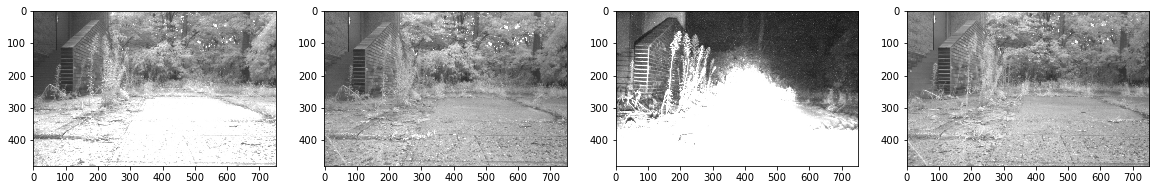

<Figure size 1440x648 with 0 Axes>

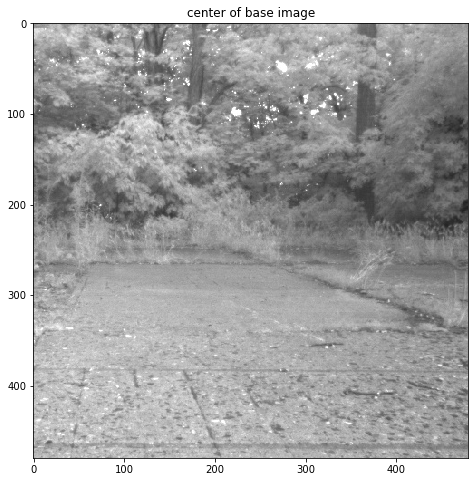

In [27]:
plt.figure(figsize=(20,9))
imshow(test_images[0], 'test image #1', 'subplot', 1,4,1)
imshow(test_images[1], 'test image #2', 'subplot', 1,4,2)
imshow(test_images[2], 'test image #3', 'subplot', 1,4,3)
imshow(test_images[3], 'test image #4', 'subplot', 1,4,4)
plt.figure(figsize=(20,9))
imshow(center_baseslice, 'center of base image')

In [36]:
slides_count = (W - H) // offset_size
sims = np.zeros((4, slides_count, 1))
base_slices_ = np.array([process_image(center_baseslice) for _ in range(slides_count)])

for i, test_image in enumerate(test_images):
    target_slices = get_slices(test_image, offset_size, slides_count)
    pair = [base_slices_, target_slices]
    similarity = model.predict(pair)
    sims[i,:] = similarity
    print(i)
sims = np.array(sims)
print(sims.shape)

0
1
2
3
(4, 272, 1)


In [39]:
for i, similarity in enumerate(sims):
    print("----------------\nTest image ", test_traversals[i], "\n")
    print(test_gt[i] + 250, '<-   true offset (in px)')
    print(np.argmax(similarity) * offset_size, ' <-   predicted offset (in px)\n')

----------------
Test image  A007 

225 <-   true offset (in px)
34  <-   predicted offset (in px)

----------------
Test image  A016 

230 <-   true offset (in px)
116  <-   predicted offset (in px)

----------------
Test image  A047 

250 <-   true offset (in px)
99  <-   predicted offset (in px)

----------------
Test image  A059 

224 <-   true offset (in px)
106  <-   predicted offset (in px)



In [39]:
for i, similarity in enumerate(sims):
    print("----------------\nTest image ", test_traversals[i], "\n")
    print(test_gt[i] + 250, '<-   true offset (in px)')
    print(np.argmax(similarity) * offset_size, ' <-   predicted offset (in px)\n')

----------------
Test image  A007 

225 <-   true offset (in px)
34  <-   predicted offset (in px)

----------------
Test image  A016 

230 <-   true offset (in px)
116  <-   predicted offset (in px)

----------------
Test image  A047 

250 <-   true offset (in px)
99  <-   predicted offset (in px)

----------------
Test image  A059 

224 <-   true offset (in px)
106  <-   predicted offset (in px)

